In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json, yaml
from collections import defaultdict
import tqdm
import matplotlib.pyplot as plt

In [13]:
ROOT = Path().cwd()
LINEAGES = ROOT.joinpath("../lineages/").resolve()
EXAMPLE = ROOT.joinpath("example")
PHYLO = Path("../lineages").resolve()

In [3]:
from pathlib import Path
from argparse import ArgumentParser

roots = {#Pangolin
        "B": "B",
        "A": "A",
        "B.1": "B.1",
        "B.1.617.2": "B.1.617.2 (Delta)",
        "B.1.621": "B.1.621 (Mu)",
        "B.1.525": "B.1.525 (Eta)",
        "B.1.617.1": "B.1.617.1 (Kappa)",
        "B.1.177": "EU1",
        "B.1.526": "B.1.526 (Iota)",
        "B.1.427": "B.1.427 (Epsilon)",
        "B.1.351": "B.1.351 (Beta)",
        "B.1.2": "B.1.2",
        "B.1.1": "B.1.1",
        "B.1.1.529": "B.1.1.529 (Omicron)",
        "P.3": "P.3 (Theta)",
        "P.1": "P.1 (Gamma)",
        "B.1.1.7": "B.1.1.7 (Alpha)",
        "D.2": "D.2",
        "B.1.1.1": "B.1.1.1",
        "C.37": "C.37 (Lambda)",
        "BA.1": "BA.1 (Omicron)",
        "BA.2": "BA.2 (Omicron)",
        "BA.3": "BA.3 (Omicron)",
        "BA.4": "BA.4 (Omicron)",
        "BA.5": "BA.5 (Omicron)",
        "XBB": "XBB (Omicron)",
        "XBB.1.5": "XBB.1.5 (Omicron)",
        "XBB.1.16": "XBB.1.16 (Omicron)",
        "XBB.1.9.1": "XBB.1.9.1 (Omicron)",
        "XBB.2.3": "XBB.2.3 (Omicron)",
        "BA.2.75": "BA.2.75 (Omicron)",
        "BA.2.12.1": "BA.2.12.1 (Omicron)",
        "BQ.1": "BQ.1 (Omicron)",
        "XBB.2.3": "XBB.2.3 (Omicron)",
        "EG.5": "EG.5 (Omicron)",
        "BA.2.86": "BA.2.86 (Omicron)",
        "JN.1": "JN.1 (Omicron)",
        #V-TRACE 
        "B.1.1.523": "B.1.1.523 (Omicron)",
        "AT.1": "AT.1",
        "BA.2.10.1": "BA.2.10.1 (Omicron)",
        "BA.4/BA.5": "BA.4/BA.5 (Omicron)",
        "XBB.1.1": "XBB.1.1 (Omicron)",
        "XBB.1.5/XBB.1.9.1": "XBB.1.5/XBB.1.9.1 (Omicron)",
        "EG.5.1": "EG.5.1 (Omicron)",
        "BF.5" : "BF.5 (Omicron)",
        "BF.7" : "BF.7 (Omicron)",
        "CL.1" : "CL.1 (Omicron)",

        "Other": "Other"}


def open_md(strain):
    to_file = [i for i in PHYLO.glob(f"**/lineage_{strain}.md")]
    if len(to_file) == 0:
        #print(f'Линия {strain} неизвестна')
        return 0
    #if len(to_file) != 1:
    #    print(f"Найдено два файла для {strain}")
    with open(to_file[0], 'r') as f:
        md_content = f.read()    
    metadata_dict = {}
    # Проходим по каждой строке и добавляем ее в словарь
    for line in md_content.split('\n')[1:-2]:
        key, value = line.split(': ', 1)
        metadata_dict[key] = value
    return metadata_dict

def find_strain_root(strain):
    metadata_dict = open_md(strain)
    if metadata_dict == 0:
        return strain
    if type(metadata_dict) != dict:
        raise KeyError(f'Линия {strain} неизвестна')
    if "parent" in metadata_dict.keys() and strain not in roots.keys(): 
        res = metadata_dict["parent"]
        return find_strain_root(res)
    else:
        return strain
    
def final_linage_name(name):
    #name.replace("пред. ", "")
    name = name.split(" ")[0]
    res = find_strain_root(name)
    if res in roots:
        res = roots[res]
    else:
        res = roots['Other']
    return res

In [4]:
def create_roots_add(path_to_lineage):
    root_count = []
    for to_file in path_to_lineage.glob(f"**/lineage*.md"):
        metadata_dict = open_md(to_file.stem.split("lineage_")[1])
        if "parent" not in metadata_dict.keys() or len(metadata_dict["parent"]) == 0:
            root_count.append(to_file.stem.split("_")[1])
    roots_add = {i: i+" (Omicron)" for i in root_count}
    return roots_add

In [5]:
%%time
df = pd.read_excel(EXAMPLE / "ежедневный_расширенный_отчёт_2024-04-08 16-00-01.xlsx")
df

CPU times: user 5min 14s, sys: 5.67 s, total: 5min 20s
Wall time: 5min 23s


,#,id последовательности,Загрузил,Загрузил образец,Название образца,Тип образца,Область секвенирования,Место забора,Место забора. Страна,Место забора. Регион,...,Загрузил сиквенс,Панголин комментарий,Заключение,Заключение комментарий,Штрихкод,Дата отправки образца,Дата принятия образца,Дата предварительного результата,Дата секвенирования,Валидность
0,1,crie000001,crie,ЦНИИ Эпидемиологии,7602069812,Первичный,Полный геном,Россия/Архангельская область/Архангельск,Россия,Архангельская область,...,ЦНИИ Эпидемиологии,Assigned from designation hash.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
1,2,crie000002,crie,ЦНИИ Эпидемиологии,7602093151,Первичный,Полный геном,Россия/Архангельская область/Архангельск,Россия,Архангельская область,...,ЦНИИ Эпидемиологии,Assigned from designation hash.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
2,3,crie000003,crie,ЦНИИ Эпидемиологии,7602087210,Первичный,Полный геном,Россия/Архангельская область/Архангельск,Россия,Архангельская область,...,ЦНИИ Эпидемиологии,Assigned from designation hash.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
3,5,hnii000001,hniiem,ФБУН «Хабаровский НИИ»,22616,Первичный,Фрагмент генома (S-белок),Россия/Хабаровский край/Хабаровск,Россия,Хабаровский край,...,ФБУН «Хабаровский НИИ»,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
4,6,hnii000002,hniiem,ФБУН «Хабаровский НИИ»,22617,Первичный,Фрагмент генома (S-белок),Россия/Хабаровский край/Хабаровск,Россия,Хабаровский край,...,ФБУН «Хабаровский НИИ»,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320147,517683,crie064501,crie_peresadina,ЦНИИ Эпидемиологии,L221V0001_7896822215,Первичный,Полный геном,Россия/Москва,Россия,г Москва,...,ЦНИИ Эпидемиологии,Usher placements: JN.1(1/1),NaN,NaN,NaN,NaN,NaN,NaN,2024-04-08 12:33:05,Валидный
320148,517684,crie064502,crie_peresadina,ЦНИИ Эпидемиологии,L231A0047_7897352456,Первичный,Полный геном,Россия/Московская область,Россия,Московская область,...,ЦНИИ Эпидемиологии,Usher placements: JN.1(1/1),NaN,NaN,NaN,NaN,NaN,NaN,2024-04-08 12:33:05,Валидный
320149,517685,crie064503,crie_peresadina,ЦНИИ Эпидемиологии,L231T0023_7896558355,Первичный,Полный геном,Россия/Московская область,Россия,Московская область,...,ЦНИИ Эпидемиологии,Usher placements: JN.1(1/1),NaN,NaN,NaN,NaN,NaN,NaN,2024-04-08 12:33:06,Валидный
320150,517686,crie064504,crie_peresadina,ЦНИИ Эпидемиологии,L231T0009_7896378879,Первичный,Полный геном,Россия/Московская область,Россия,Московская область,...,ЦНИИ Эпидемиологии,Usher placements: JN.1(1/1),NaN,NaN,NaN,NaN,NaN,NaN,2024-04-08 12:33:06,Валидный


In [6]:
df = df[df["Валидность"] == "Валидный"]

In [7]:
df[["Генетический вариант(Скрипт VGARus)", "Pangolin"]] = df[["Генетический вариант(Скрипт VGARus)", "Pangolin"]].astype(str) 

/tmp/ipykernel_6048/2050758251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["Генетический вариант(Скрипт VGARus)", "Pangolin"]] = df[["Генетический вариант(Скрипт VGARus)", "Pangolin"]].astype(str)


In [8]:
mask = df["Pangolin"].isin(["nan"])
df = df[~mask]

In [17]:
sars_c_2_df_tail = df.tail(50)

In [18]:
sars_c_2_df_tail["Pangolin_collapse"] = sars_c_2_df_tail["Pangolin"].apply(lambda x: final_linage_name(x))

/tmp/ipykernel_6048/3053150892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sars_c_2_df_tail["Pangolin_collapse"] = sars_c_2_df_tail["Pangolin"].apply(lambda x: final_linage_name(x))


In [19]:
sars_c_2_df_tail[["Генетический вариант(Скрипт VGARus)", "Pangolin", "Pangolin_collapse"]]

,Генетический вариант(Скрипт VGARus),Pangolin,Pangolin_collapse
320100,nan,JN.1 Omicron (BA.2-like),JN.1 (Omicron)
320101,nan,JN.1 Omicron (BA.2-like),JN.1 (Omicron)
320102,nan,XBB.1.16.28 Omicron (XBB.1.16-like),XBB.1.16 (Omicron)
320103,nan,JN.1 Omicron (BA.2-like),JN.1 (Omicron)
320104,nan,JN.1 Omicron (BA.2-like),JN.1 (Omicron)
320105,nan,JN.1 Omicron (BA.2-like),JN.1 (Omicron)
320106,nan,JN.1 Omicron (BA.2-like),JN.1 (Omicron)
320107,nan,JN.1 Omicron (BA.2-like),JN.1 (Omicron)
320108,nan,XBB.1.16.28 Omicron (XBB.1.16-like),XBB.1.16 (Omicron)
320110,nan,XBB.1.16.11 Omicron (XBB.1.16-like),XBB.1.16 (Omicron)


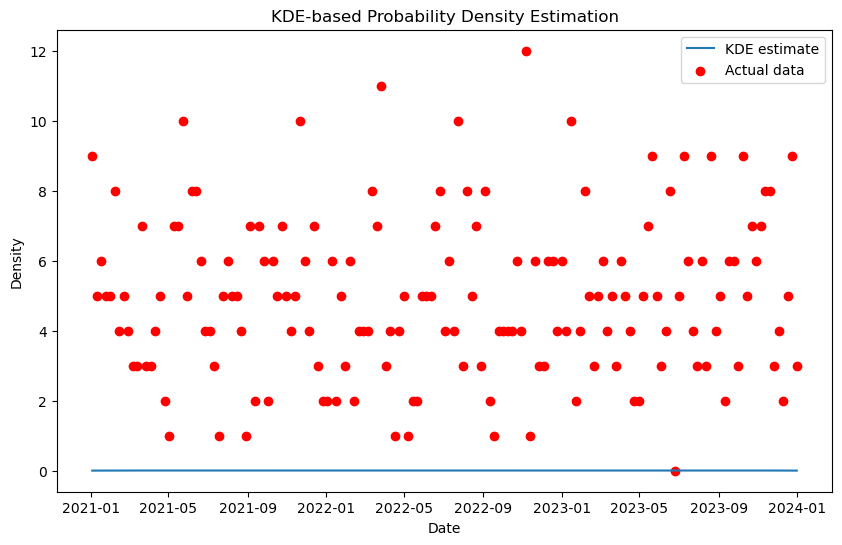

Probability of the new sequence count fitting the existing pattern: 0.0029306100124831653


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Генерация искусственных данных
np.random.seed(0)
dates = pd.date_range(start="2021-01-01", end="2024-01-01", freq="W")
n_weeks = len(dates)
sequence_counts = np.random.poisson(lam=5, size=n_weeks)  # Количество последовательностей за неделю

# Создание DataFrame
df = pd.DataFrame({
    'date': dates,
    'sequence_count': sequence_counts
})

# Фильтрация по конкретному варианту (например, BA.2)
df['variant'] = 'BA.2'
# Здесь можно заменить фильтрацию на реальных данных
# df = df[df['variant'] == 'BA.2']

# Построение ядровой оценки плотности (KDE) для моделирования вероятности
weeks = np.array(range(n_weeks)).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(weeks, df['sequence_count'])
log_density = kde.score_samples(weeks)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(df['date'], np.exp(log_density), label='KDE estimate')
plt.scatter(df['date'], df['sequence_count'], color='red', label='Actual data')
plt.title('KDE-based Probability Density Estimation')
plt.xlabel('Date')
plt.ylabel('Density')
plt.legend()
plt.show()

# Оценка вероятности новой последовательности
new_date_index = len(dates)  # например, новая неделя
new_count = 20  # количество новых последовательностей

# Вычисление плотности для новой даты
log_prob = kde.score_samples(np.array([[new_date_index]]))[0]
prob = np.exp(log_prob)

print(f"Probability of the new sequence count fitting the existing pattern: {prob}")


In [4]:
kde

KernelDensity(bandwidth=5)